In [75]:
import warnings

with warnings.catch_warnings():
    warnings.filterwarnings("ignore", message="numpy.dtype size changed")
    warnings.filterwarnings("ignore", message="numpy.ufunc size changed")
    warnings.filterwarnings("ignore", category=FutureWarning)
    
    import keras 
    print(keras.__version__) 

2.1.5


# Perceptual Losses for Real-Time Style Transfer and Super-Resolution

Keras implementation of the network described in<a href='https://arxiv.org/abs/1603.08155'>Perceptual Losses for Real-Time Style Transfer and Super-Resolution by Justin Johnson, Alexandre Alahi, Li Fei-Fei</a> in in March 2016. 

The implementation is based on what was described in the <a href='http://course.fast.ai/lessons/lesson9.html'>FastAI's course on Generative Models</a>.

In [76]:
%matplotlib inline

import importlib

import matplotlib
import matplotlib.pyplot as plt

from scipy.optimize import fmin_l_bfgs_b
from scipy.misc import imsave
import numpy as np
from PIL import Image # used to load images
import glob 

import tensorflow as tf

from keras.applications.vgg16 import VGG16
from keras.applications.vgg16 import preprocess_input, decode_predictions
from keras import backend as K

from vgg16_avg import VGG16_Avg

In [77]:
TARGET_SIZE = (320,320)

## Training Data 

Dataset from Fast.ai and can be downloaded from <a href='http://files.fast.ai/data/imagenet-sample-train.tar.gz'>here</a>. 

### Preprocessing 

We'll be using this image with VGG16. Therefore, we need to subtract the mean of each channel of the imagenet data and reverse the order of RGB->BGR since those are the preprocessing steps that the VGG authors did - so their model won't work unless we do the same thing.

In [78]:
def load_resize_image(img_path, target_size=TARGET_SIZE, preprocess_required=False):
    """
    
    """
    # Load image 
    img = Image.open(img_path)
    if img.mode is not "RGB":
        img = img.convert('RGB')
    
    if preprocess_required:
        # Get dimensions
        img_width, img_height = img.size
        half_img_width, half_img_height = img_width/2.0, img_height/2.0

        # Crop
        target_width = min(img_width, img_height)
        target_height = min(img_width, img_height)

        left = half_img_width - target_width/2
        top = half_img_height - target_height/2
        right = half_img_width + target_width/2
        bottom = half_img_height + target_height/2

        img = img.crop((left, top, right, bottom))

        # Resize 
        img = img.resize(target_size)
    
    return img 

In [79]:
rn_mean = np.array([123.68, 116.779, 103.939], dtype=np.float32)

In [80]:
def preproc(x):     
    return (x-rn_mean)[:, :, :, ::-1]

When we generate images from this network, we'll need to undo the above preprocessing in order to view them.

In [81]:
def deproc(x, shape):
    return np.clip(x.reshape(shape)[:, :, :, ::-1] + rn_mean, 0, 255)

Load the style image 

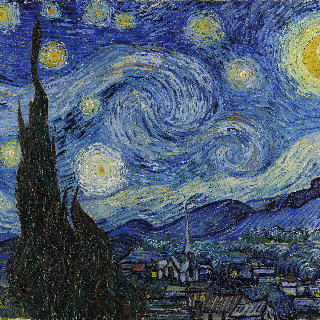

In [82]:
style = load_resize_image('data/Van_Gogh-Starry_Night.jpg', preprocess_required=True)
style

--- 

## Load model architecture and weights

In [83]:
class ReflectionPadding2D(keras.layers.Layer):
    def __init__(self, padding=(1, 1), **kwargs):
        self.padding = tuple(padding)        
        self.input_spec = [keras.layers.InputSpec(ndim=4)]
        super(ReflectionPadding2D, self).__init__(**kwargs)
        
    def compute_output_shape(self, s):
        return (s[0], s[1] + 2 * self.padding[0], s[2] + 2 * self.padding[1], s[3])

    def call(self, x, mask=None):
        w_pad,h_pad = self.padding
        return tf.pad(x, [[0,0], [h_pad,h_pad], [w_pad,w_pad], [0,0] ], 'REFLECT')
    
    def get_config(self):
        return super(ReflectionPadding2D, self).get_config()

In [84]:
# from keras.models import model_from_json
# with open('output/van-gogh-starry-night_style.json', 'r') as f:
#     with keras.utils.CustomObjectScope({'ReflectionPadding2D': ReflectionPadding2D}):
#         model = model_from_json(f.read())

### Build Model 
(failed to load architecture - issue with Python 3 -> 2.7)

In [85]:
def conv_block(x, filters, size, stride=(2,2), mode='same', act=True):
    x = keras.layers.Conv2D(filters, kernel_size=(size, size), strides=stride, padding=mode)(x)
    x = keras.layers.BatchNormalization()(x)
    return keras.layers.Activation('relu')(x) if act else x

In [86]:
def up_block(x, filters, size):
    x = keras.layers.UpSampling2D()(x)
    x = keras.layers.Conv2D(filters, kernel_size=(size, size), padding='same')(x)
    x = keras.layers.BatchNormalization()(x)
    return keras.layers.Activation('relu')(x)

In [87]:
def res_crop(x):
    return x[:, 2:-2, 2:-2]

def res_crop_block(ip, nf=64, block_idx=0):
    x = conv_block(ip, nf, 3, (1,1), 'valid')
    x = conv_block(x,  nf, 3, (1,1), 'valid', False)
    ip = keras.layers.Lambda(res_crop, name='res_crop_{}'.format(block_idx))(ip)
    return keras.layers.add([x, ip])    

In [88]:
def rescale_output(x):
    return (x+1)*127.5

shp = (320, 320, 3)
inp=keras.layers.Input(shp)

#x=ReflectionPadding2D((40, 40))(inp)
x = keras.layers.ZeroPadding2D(padding=(40, 40))(inp)

x=conv_block(x, 64, 9, (1,1))
x=conv_block(x, 64, 3)
x=conv_block(x, 64, 3)
for i in range(5): x=res_crop_block(x, 64, i)
x=up_block(x, 64, 3)
x=up_block(x, 64, 3)
x=keras.layers.Conv2D(3, kernel_size=(9, 9), activation='tanh', padding='same')(x)
outp=keras.layers.Lambda(rescale_output, name='rescale_output')(x)

In [89]:
vgg_inp=keras.layers.Input(shp)
vgg = VGG16(include_top=False, input_tensor=keras.layers.Lambda(preproc)(vgg_inp))
for l in vgg.layers: l.trainable=False

In [90]:
def get_outp(m, ln): 
    return m.get_layer("block{}_conv2".format(ln)).output    

In [91]:
vgg_content = keras.models.Model(vgg_inp, [get_outp(vgg, o) for o in [2,3,4,5]])

In [92]:
style_targs = [K.variable(o) for o in
               vgg_content.predict(np.expand_dims(style,0))]

In [93]:
[K.eval(K.shape(o)) for o in style_targs]

[array([  1, 160, 160, 128], dtype=int32),
 array([  1,  80,  80, 256], dtype=int32),
 array([  1,  40,  40, 512], dtype=int32),
 array([  1,  20,  20, 512], dtype=int32)]

In [94]:
vgg1 = vgg_content(vgg_inp)
vgg2 = vgg_content(outp)

In [95]:
def mean_sqr_b(diff): 
    dims = list(range(1,K.ndim(diff)))
    return K.expand_dims(K.sqrt(K.mean(diff**2, dims)), 0)

In [96]:
def gram_matrix_b(x):
    x = K.permute_dimensions(x, (0, 3, 1, 2))
    s = K.shape(x)
    feat = K.reshape(x, (s[0], s[1], s[2]*s[3]))
    return K.batch_dot(feat, K.permute_dimensions(feat, (0, 2, 1))
                      ) / K.prod(K.cast(s[1:], K.floatx()))

In [97]:
w=[0.1, 0.2, 0.6, 0.1]

def tot_loss(x):
    loss = 0 
    n = len(style_targs)
    for i in range(n):
        loss += mean_sqr_b(gram_matrix_b(x[i+n]) - gram_matrix_b(style_targs[i])) / 2.
        loss += mean_sqr_b(x[i]-x[i+n]) * w[i]
    return loss

In [98]:
loss = keras.layers.Lambda(tot_loss)(vgg1+vgg2)
m_style = keras.models.Model([inp, vgg_inp], loss)

In [99]:
m_style.compile('adam', 'mae')

In [100]:
K.set_value(m_style.optimizer.lr, 1e-4)

In [101]:
model = keras.models.Model(inp, outp)

In [102]:
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            (None, 320, 320, 3)  0                                            
__________________________________________________________________________________________________
zero_padding2d_2 (ZeroPadding2D (None, 400, 400, 3)  0           input_3[0][0]                    
__________________________________________________________________________________________________
conv2d_17 (Conv2D)              (None, 400, 400, 64) 15616       zero_padding2d_2[0][0]           
__________________________________________________________________________________________________
batch_normalization_16 (BatchNo (None, 400, 400, 64) 256         conv2d_17[0][0]                  
__________________________________________________________________________________________________
activation

In [103]:
# By inspecting the custom res_crop layer we can see that it just crops the shape by 2
res_crop_3_layer = [layer for layer in model.layers if layer.name == 'res_crop_3'][0] 
print("res_crop_3_layer input shape {}, output shape {}".format(
    res_crop_3_layer.input_shape, res_crop_3_layer.output_shape))

res_crop_3_layer input shape (None, 88, 88, 64), output shape (None, 84, 84, 64)


In [104]:
rescale_output_layer = [layer for layer in model.layers if layer.name == 'rescale_output'][0]
print("rescale_output_layer input shape {}, output shape {}".format(
    rescale_output_layer.input_shape, 
    rescale_output_layer.output_shape))

rescale_output_layer input shape (None, 320, 320, 3), output shape (None, 320, 320, 3)


In [105]:
model.load_weights('output/van-gogh-starry-night_style_2.h5')

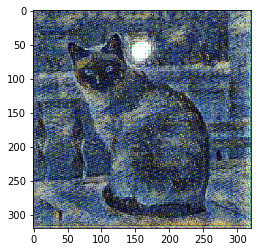

In [106]:
img = load_resize_image('data/cat.jpg', preprocess_required=True) 
img = np.asarray(img, dtype='float32')
img = np.expand_dims(img, 0)
p = model.predict(img)
plt.imshow(np.round(p[0]).astype('uint8'));

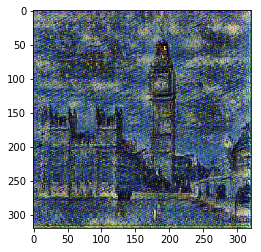

In [107]:
img = load_resize_image('data/london_big-ben.jpg', preprocess_required=True) 
img = np.asarray(img, dtype='float32')
img = np.expand_dims(img, 0)
p = model.predict(img)
plt.imshow(np.round(p[0]).astype('uint8'));

## Convert to CoreML

**References**  
https://apple.github.io/coremltools/generated/coremltools.models.neural_network.html

In [108]:
import coremltools

In [109]:
from coremltools.proto import NeuralNetwork_pb2

def convert_lambda(layer):
    print(layer.function)
    if layer.function == rescale_output:
        params = NeuralNetwork_pb2.CustomLayerParams()

        # The name of the Swift or Obj-C class that implements this layer.
        params.className = "RescaleOutputLambda"

        # The desciption is shown in Xcode's mlmodel viewer.
        params.description = "Rescale output to adjust for ReLu ((x+1)*127.5)"

        return params
    elif layer.function == res_crop:
        params = NeuralNetwork_pb2.CustomLayerParams()

        # The name of the Swift or Obj-C class that implements this layer.
        params.className = "ResCropBlockLambda"

        # The desciption is shown in Xcode's mlmodel viewer.
        params.description = "return x[:, 2:-2, 2:-2]"

        return params
    else:
        print("UNKNOWN LAYER")
    return None

In [110]:
coreml_model = coremltools.converters.keras.convert(model, 
                                                    input_names=['image'], 
                                                    image_input_names=['image'], 
                                                    output_names="output",
                                                    add_custom_layers=True,
                                                    custom_conversion_functions={ "Lambda": convert_lambda })

0 : input_3, <keras.engine.topology.InputLayer object at 0x182839fbd0>
1 : zero_padding2d_2, <keras.layers.convolutional.ZeroPadding2D object at 0x182839fc10>
2 : conv2d_17, <keras.layers.convolutional.Conv2D object at 0x182839fcd0>
3 : batch_normalization_16, <keras.layers.normalization.BatchNormalization object at 0x182839fd10>
4 : activation_12, <keras.layers.core.Activation object at 0x181ee4ebd0>
5 : conv2d_18, <keras.layers.convolutional.Conv2D object at 0x181ce168d0>
6 : batch_normalization_17, <keras.layers.normalization.BatchNormalization object at 0x182839fc50>
7 : activation_13, <keras.layers.core.Activation object at 0x18221da9d0>
8 : conv2d_19, <keras.layers.convolutional.Conv2D object at 0x18234eb450>
9 : batch_normalization_18, <keras.layers.normalization.BatchNormalization object at 0x18234ebf90>
10 : activation_14, <keras.layers.core.Activation object at 0x18277b6ed0>
11 : conv2d_20, <keras.layers.convolutional.Conv2D object at 0x182d89af90>
12 : batch_normalization_19

In [111]:
coreml_model.author = 'Joshua Newnham'
coreml_model.license = 'BSD'
coreml_model.short_description = 'FastStyle Transfer with style Van Gogh Starry Night'
coreml_model.input_description['image'] = 'Preprocessed content image'
coreml_model.output_description['output'] = 'Stylized content image'

In [112]:
coreml_model.save('output/FastStyleTransferVanGoghStarryNight.mlmodel')

In [119]:
spec = coreml_model.get_spec()
for output in spec.description.output:  
    print(output.name)

output


For convenience we will convert the output to a Image (method taken from https://hackernoon.com/diy-prisma-fast-style-transfer-app-with-coreml-and-tensorflow-817c3b90dacd)   

In [113]:
def convert_multiarray_output_to_image(model, feature_name, is_bgr=False):  
    """  
    Convert an output multiarray to be represented as an image  
    This will modify the Model_pb spec passed in.  
    Example:  
        model = coremltools.models.MLModel('MyNeuralNetwork.mlmodel')  
        spec = model.get_spec()  
        convert_multiarray_output_to_image(spec,'imageOutput',is_bgr=False)  
        newModel = coremltools.models.MLModel(spec)  
        newModel.save('MyNeuralNetworkWithImageOutput.mlmodel')  
    Parameters  
    ----------  
    spec: Model_pb  
        The specification containing the output feature to convert  
    feature_name: str  
        The name of the multiarray output feature you want to convert  
    is_bgr: boolean  
        If multiarray has 3 channels, set to True for RGB pixel order or false for BGR  
    """  
    
    spec = model.get_spec() 
    
    for output in spec.description.output:  
        if output.name != feature_name:  
            continue  
        if output.type.WhichOneof('Type') != 'multiArrayType':  
            raise ValueError("%s is not a multiarray type" % output.name)  
        array_shape = tuple(output.type.multiArrayType.shape)  
        channels, height, width = array_shape  
        from coremltools.proto import FeatureTypes_pb2 as ft  
        if channels == 1:  
            output.type.imageType.colorSpace = ft.ImageFeatureType.ColorSpace.Value('GRAYSCALE')  
        elif channels == 3:  
            if is_bgr:  
                output.type.imageType.colorSpace = ft.ImageFeatureType.ColorSpace.Value('BGR')  
            else:  
                output.type.imageType.colorSpace = ft.ImageFeatureType.ColorSpace.Value('RGB')  
        else:  
            raise ValueError("Channel Value %d not supported for image inputs" % channels)  
            
        output.type.imageType.width = width  
        output.type.imageType.height = height
        
    return coremltools.models.MLModel(spec)  

In [120]:
converted_output_coreml_model = convert_multiarray_output_to_image(
    coreml_model,
    'output',
    is_bgr=False)  

In [121]:
converted_output_coreml_model.save('output/FastStyleTransferVanGoghStarryNight.mlmodel')